In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost
import scipy
import warnings
import itertools

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.pipeline import Pipeline
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, matthews_corrcoef, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

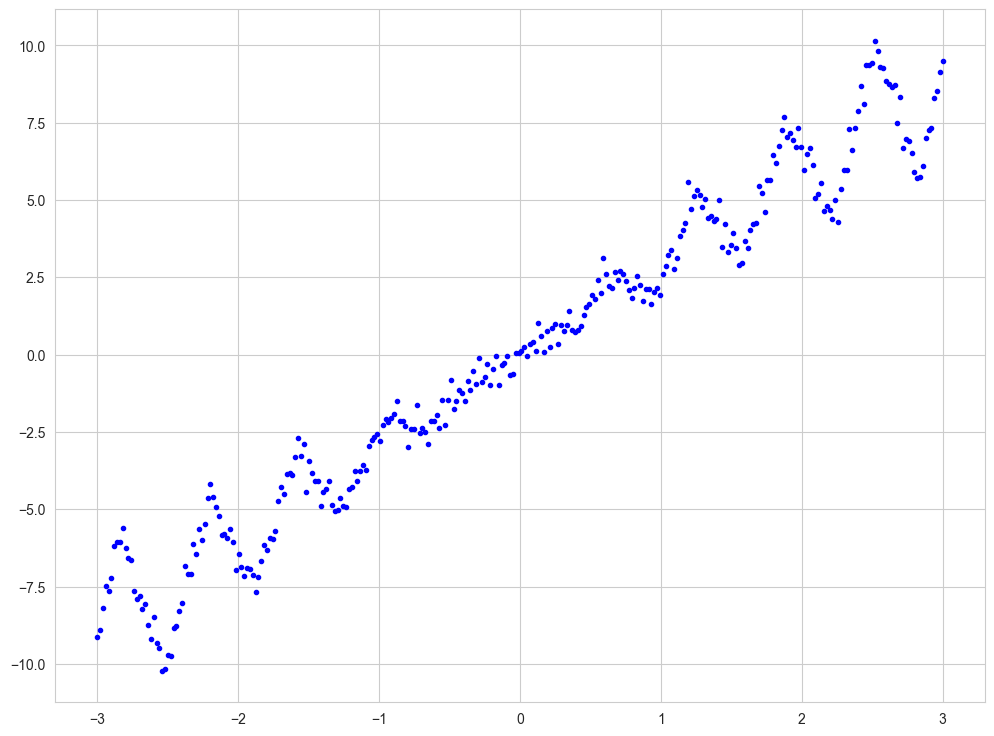

In [6]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [7]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=13)
    if ylabel:
        plt.ylabel(ylabel, fontsize=13, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$", color= '#9b2d30')

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

<span style='color: green;'>Поделим выборку на train и test</span> 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= SEED, test_size=0.30)

<span style='color: green;'>Посмотрим как будут менятся предсказания деревьев в зависимости от глубины </span> 

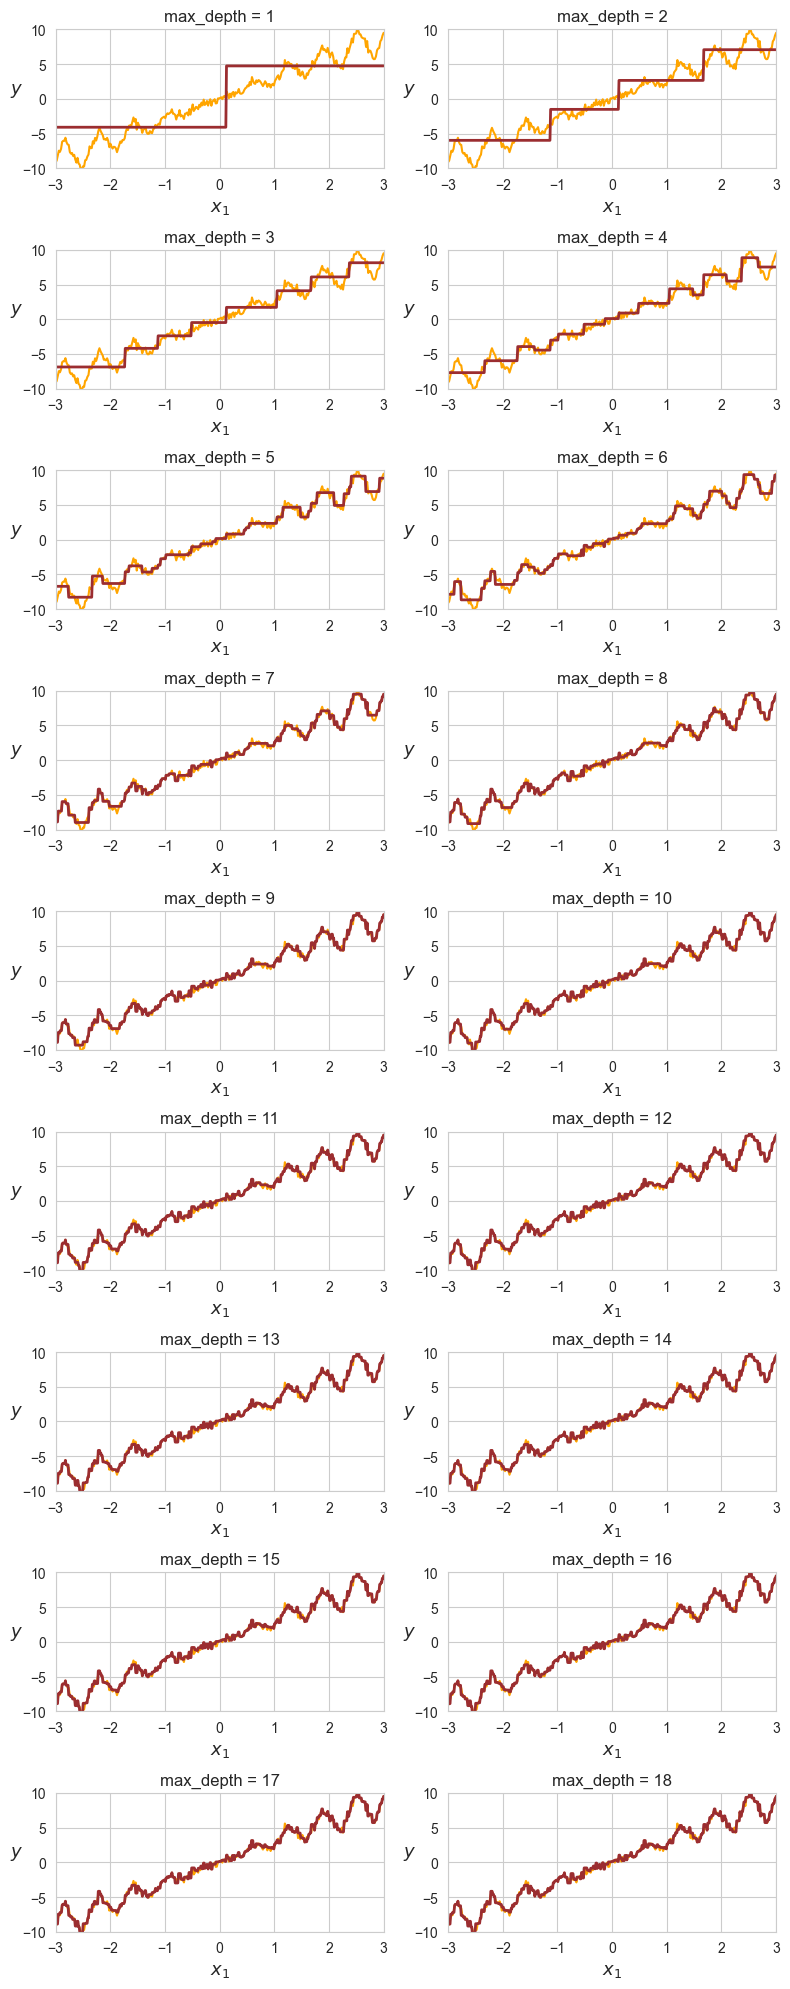

In [11]:
#Задаем максимальное количество глубин (от 1 до 18)
max_depth = [i for i in range(1,19)]
#Строим деревья с параметром max_depth и смотрим на график предсказанных значений
plt.figure(figsize=(8,20))
for i, depth in enumerate(max_depth):
    plt.subplot(9,2,i+1)
    tree_model = DecisionTreeRegressor(max_depth=depth, random_state=SEED)
    tree_model.fit(X_train, y_train)
    plt.plot(X.reshape(-1), y.reshape(-1), color = "orange")
    plot_regression_predictions(tree_model, X_test, y_test)
    plt.title(f"max_depth = {depth}")
    plt.tight_layout(h_pad= 1)

<span style='color: green;'>Видим, что при увеличении параметра max_depth увеличивается способность модели правильно предсказывать значения данных со сложной зависимостью. Модели с маленьким количеством max_depth (1,2,3,4) недообучены, они не видят сложную зависимость в данных. Модели с большим количеством в max_depth уже лучше предсказывают значения, но у них увеличивается variance. При max_depth > 10 модели уже становятся переобученными, обладают высоким variance. На мой взгляд наиболее оптимальным значением max_depth будет 7 - 8. </span> 

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [12]:
#Сделаем функцию, которая будет считать mu в зависимости от p для моделей и количества моделей.
def maj_vote(n, p):
    return np.sum([scipy.special.comb(n, i) * (p**i) * (1-p)**(n-i) for i in range((n//2) + n%2, n + 1)])

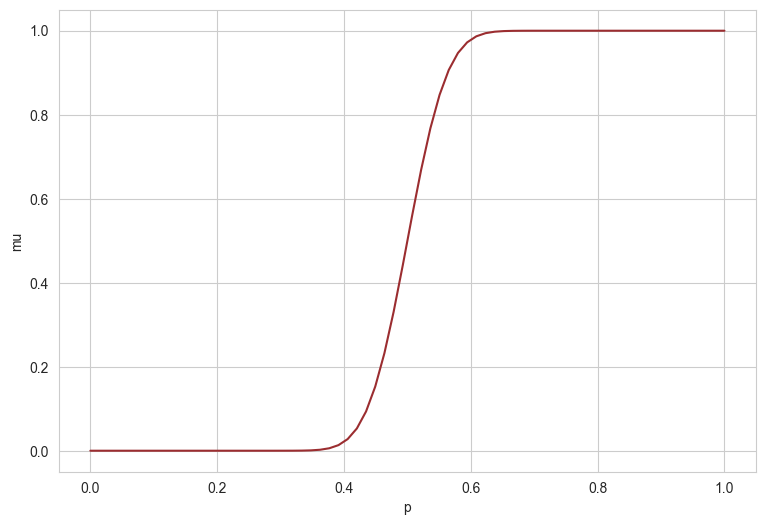

In [13]:
ps = np.linspace(0,1,70)
mus = []
for p in ps:
    mus.append(maj_vote(101, p))
#Построим график
plt.figure(figsize=(9,6))
plt.plot(ps,mus, color = '#9b2d30')
plt.xlabel('p')
plt.ylabel('mu');    

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

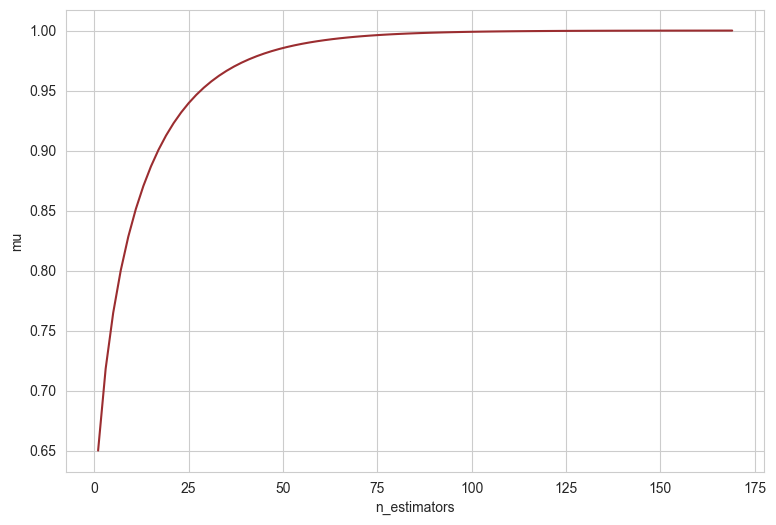

In [14]:
n_estimators = np.arange(1, 170, 2, dtype= int)
mus = []
for n in n_estimators:
    mus.append(maj_vote(n, 0.65))

#Построим график
plt.figure(figsize=(9,6))
plt.plot(n_estimators, mus, color = '#9b2d30')
plt.xlabel('n_estimators')
plt.ylabel('mu');  


Опишите ваши наблюдения:

* На первом графике видим, что функция возрастает при p = 0.4 - 0.6. При p < 0.4 вероятность правильной классификации близится к 0, а при p > 0.6 приближается к 1. Соответственно даже при p = 0.6 для каждой модели - суммарная вероятность правильно классифицировать объекты высокая. 
* На втором графике видим, что при p = 0.65 способность моделей классифицировать объекты увеличивается с увеличением количества моделей (количества голосов) в ансамбле. Для того, чтобы достичь хорошей классификации согласно графику надо хотя бы 80 моделей и соответственно 80 голосов.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [15]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        n_features = X.shape[1]
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            
            #Рандомно выберем признаки для построения дерева (признаки не повторяются внутри одного дерева, max_features - количество признаков, которое берем)
            self.feat_ids_by_tree.append(np.random.choice(np.arange(n_features), self.max_features, replace = False))
            
            #Сделаем псевдовыборки с использованием бутстрепа 
            pseudo_index = np.random.choice(np.arange(X.shape[0]), X.shape[0], replace = True)
            pseudo_x = X[pseudo_index, :][:, self.feat_ids_by_tree[i]]
            pseudo_y = y[pseudo_index]
            
            #Обучим дерево решений с параметрами max_depth, max_features, random_state
            dt_model = DecisionTreeClassifier(max_depth = self.max_depth, max_features= self.max_features, random_state = self.random_state + i)
            dt_model.fit(pseudo_x, pseudo_y)
            
            #Добавим дерево в список деревьев
            self.trees.append(dt_model)
        return self
            
    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        
        pred_prob = []
        for i in range(self.n_estimators):
            pred_prob.append(self.trees[i].predict_proba(X[:, self.feat_ids_by_tree[i]]))
        return np.mean(pred_prob, axis = 0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [16]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

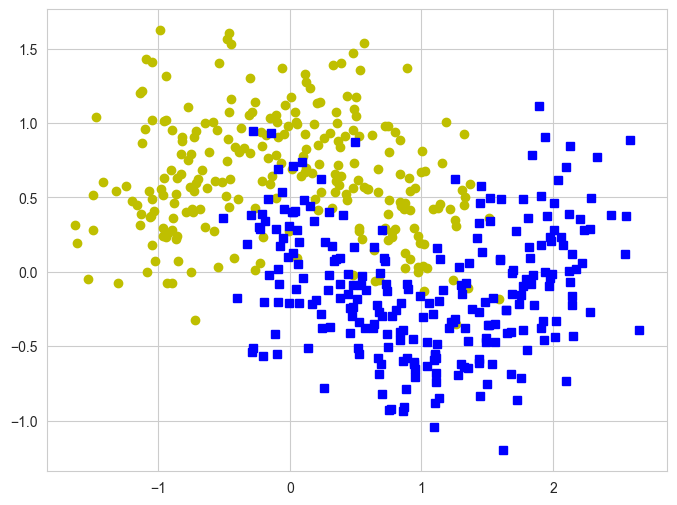

In [17]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

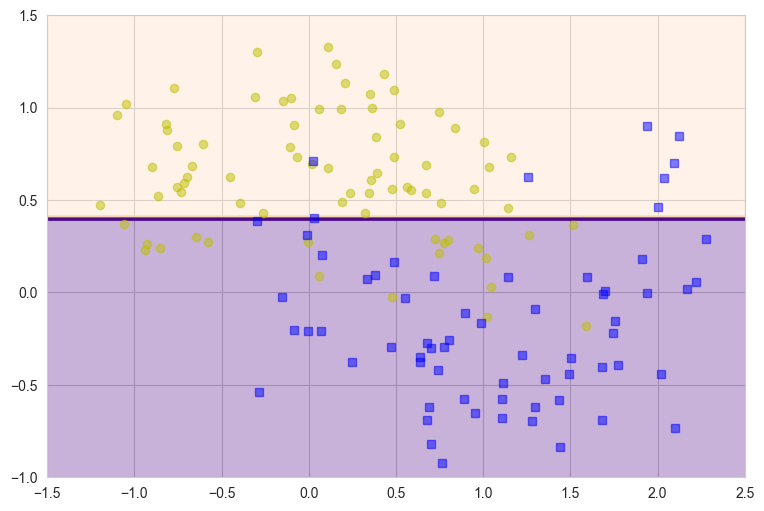

In [18]:
plt.figure(figsize=(9,6))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=SEED)
rf_model = RandomForestClassifierCustom(max_depth=1, n_estimators=1000, max_features=2)
rf_model.fit(X_train, y_train)
plot_decision_boundary(rf_model, X_test, y_test)
plt.xlabel("")
plt.ylabel("");

<span style='color: green;'>Что ж наш кастомный RandomForest как-то работает! Это уже успех, я считаю)</span> 


Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

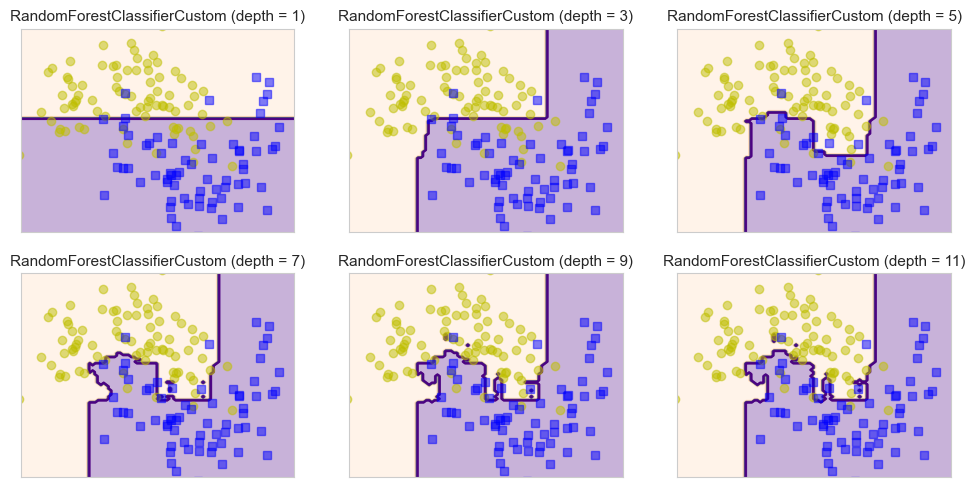

In [19]:
plt.figure(figsize=(12,9))
max_depth = [i for i in range(1, 12, 2)]

for i, depth in enumerate(max_depth):
    plt.subplot(3,3,i+1)
    rf_model = RandomForestClassifierCustom(max_depth=depth, n_estimators=1000, max_features=2)
    rf_model.fit(X_train, y_train)
    plot_decision_boundary(rf_model, X_test, y_test)
    plt.title(f"RandomForestClassifierCustom (depth = {depth})", size = 11)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([], [])
    plt.yticks([], []);

<span style='color: green;'>Видим, что при увеличении глубины дерева увеличивается variance и уменьшается bias. При depth 1-3 модель явно недообучена и плохо будет будет предсказывать значения. Наиболее оптимальная глубина примерно 5-7 (более ровная граница раздела).</span> 

<span style='color: green;'>Посмотри как будет себя вести модель с параметром depth = 10 на разных разбиениях выборки. Предполагается, что у нее низкий bias и она будет нестабильна.</span> 

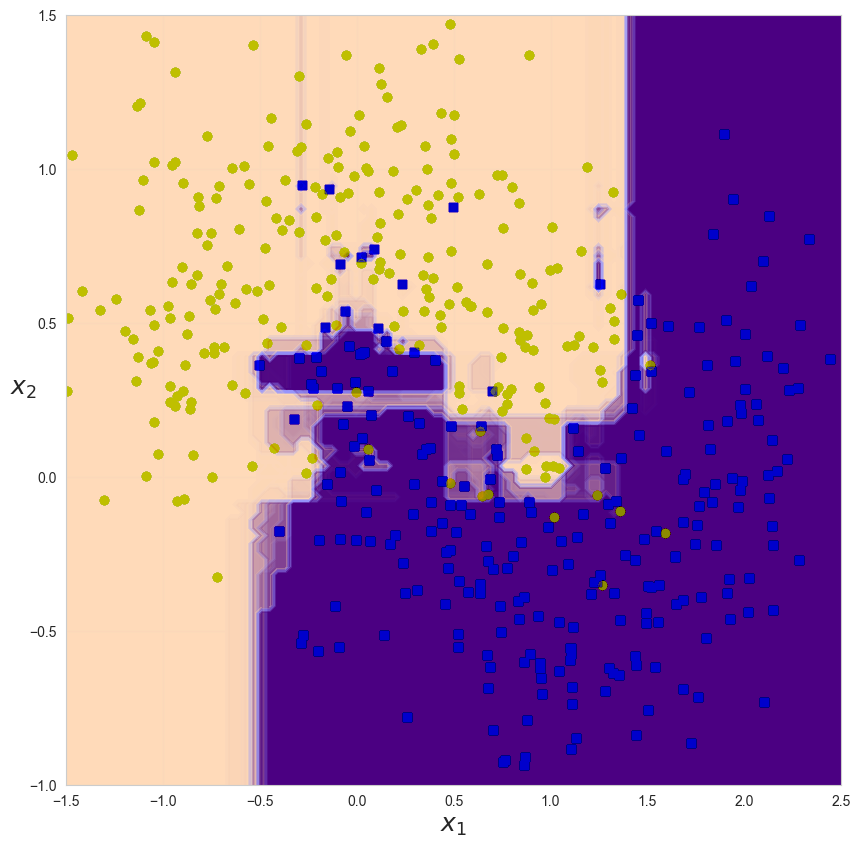

In [21]:
plt.figure(figsize=(10, 10))

for i in range(20, 130):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    rf_model = RandomForestClassifierCustom(max_depth=10, n_estimators=500, max_features=2)
    rf_model.fit(X_train, y_train)
    plot_decision_boundary(rf_model, X, y, alpha=0.02, contour=False)
    
plt.show()

<span style='color: green;'> Как мы и предполагали, на рисунке видно, что при max_depth = 10 модель имеет низкий bias и высокий variance. Модель нестабильна и при разном разбиении на train и test предсказывает значения по-разному.</span> 

<span style='color: green;'>Посмотрим также на границу раздела для нескольких моделей с параметром max_depth = 5 (Согласно графикам выше мы решили, что этот параметр будет оптимальным). Будет ли модель более стабильно предсказывать значения? </span> 

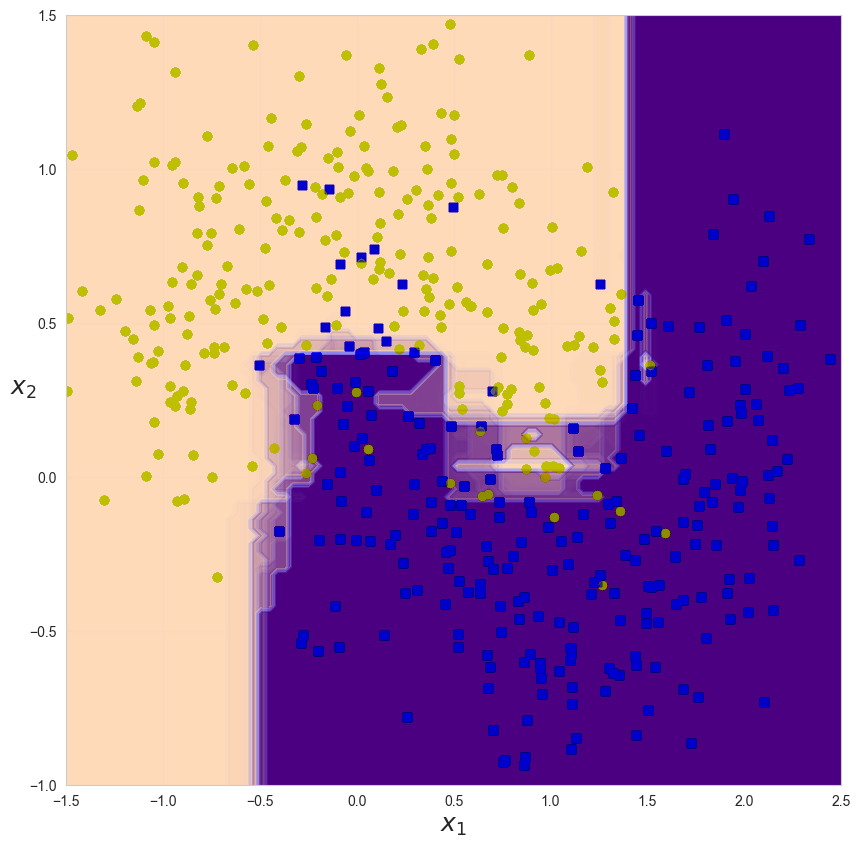

In [22]:
plt.figure(figsize=(10, 10))

for i in range(20, 130):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    rf_model = RandomForestClassifierCustom(max_depth=5, n_estimators=500, max_features=2)
    rf_model.fit(X_train, y_train)
    plot_decision_boundary(rf_model, X, y, alpha=0.02, contour=False)
    
plt.show()

<span style='color: green;'>Что ж в целом модель стала более стабильна. Но все равно различия между предсказаниями на разных разбиениях данных есть. </span> 

<span style='color: green;'>А сейчас переберем одновременно параметры max_depth и n_estimators  </span> 

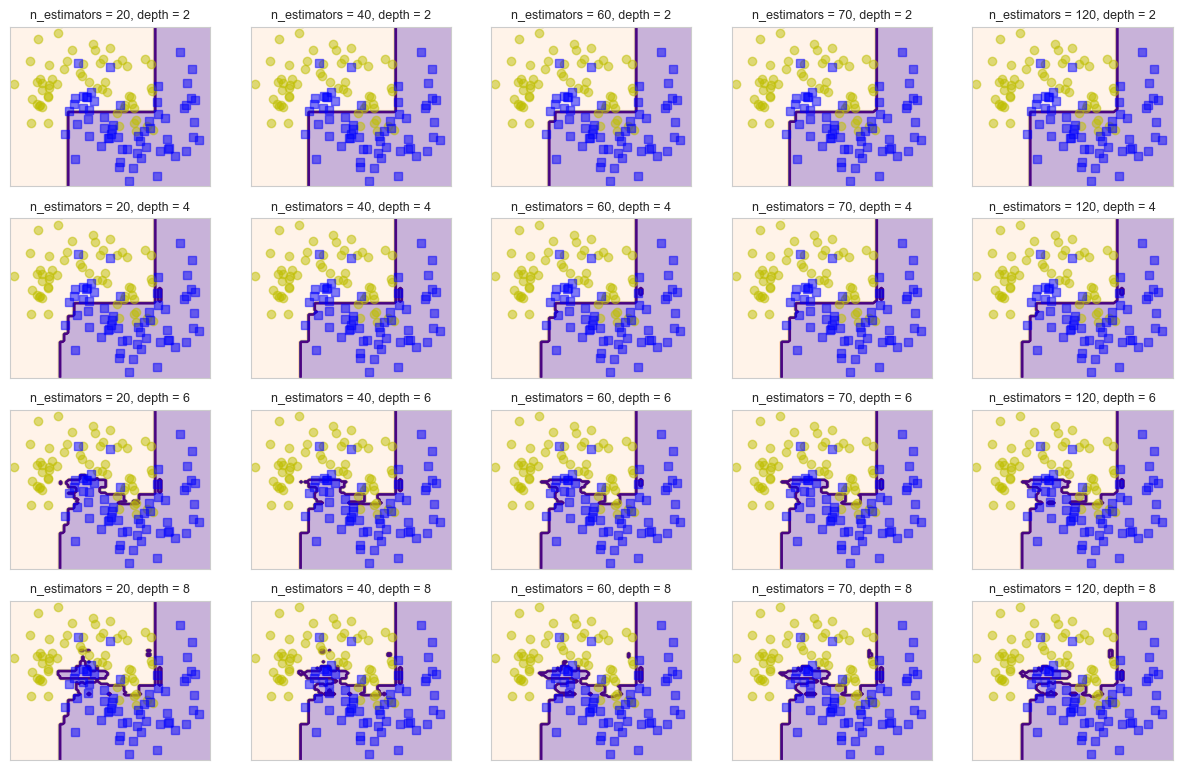

In [23]:
plt.figure(figsize=(15,12))
n_estimators = [20, 40, 60, 70, 120]
subplot_ind = 1
for depth in [2,4,6,8]:
    for n in n_estimators:
        plt.subplot(5,5,subplot_ind )
        rf_model = RandomForestClassifierCustom(max_depth=depth, n_estimators=n, max_features=2)
        rf_model.fit(X_train, y_train)
        plot_decision_boundary(rf_model, X_test, y_test)
        plt.title(f"n_estimators = {n}, depth = {depth}", size = 9)
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([], [])
        plt.yticks([], [])
        subplot_ind +=1;

<span style='color: green;'>При значении depth = 6 и n_estimators в райне 60-70 модель имеет оптимальную границу раздела. При высоких значениях depth и n_estimators граница ломаная - модель явно переобучена. При маленьких значениях - модель недообучена, плохо разделяет данные. </span> 

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выяcнили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [34]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [35]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [71]:
#Создадим случайный лес с разным параметром max_features и посмотрим как это будет влиять корреляцию базовых моделей внутри
max_features = [2, 4, 6, 8, 10, 15, 20, 25, 30, 40]
result_corr = []
for i in max_features:
    rf_model = RandomForestClassifier(max_features=i)
    rf_model.fit(X_train, y_train)
    result_corr.append(base_model_pair_correlation(rf_model, X_test))

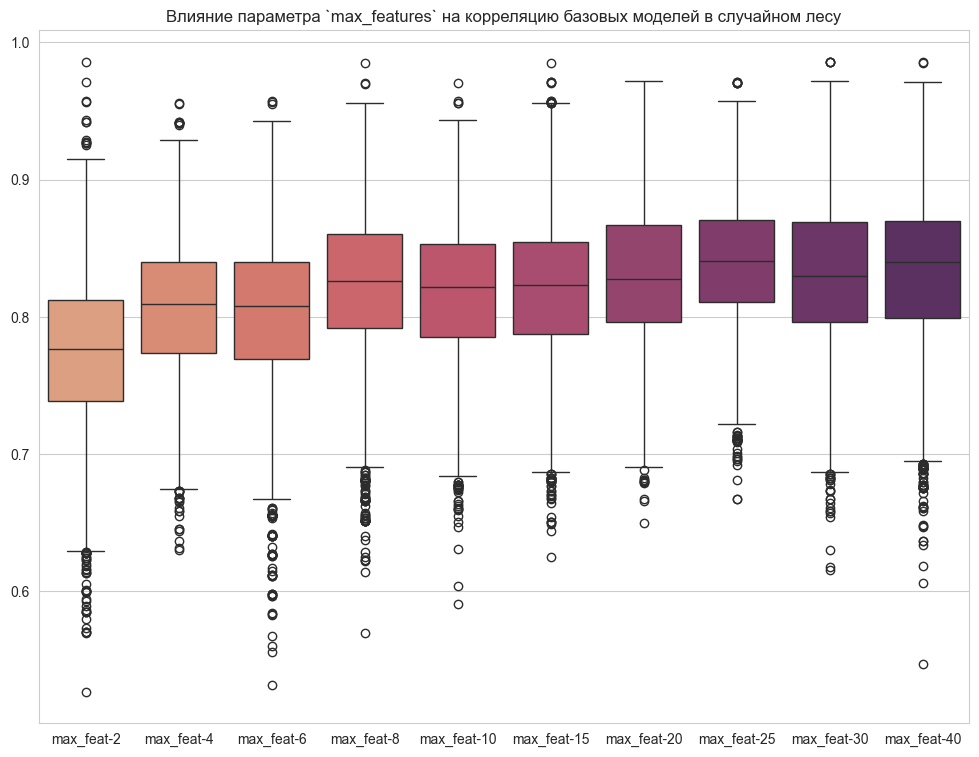

In [73]:
ax = sns.boxplot(result_corr, palette = 'flare')
label_list = ['max_feat-2','max_feat-4','max_feat-6','max_feat-8','max_feat-10','max_feat-15','max_feat-20','max_feat-25','max_feat-30','max_feat-40']
ax.set_xticklabels(label_list)
plt.title('Влияние параметра `max_features` на корреляцию базовых моделей в случайном лесу');

<span style='color: green;'>Теперь давайте посмотрим, как на это влияет параметр `max_depth`:</span> 

In [83]:
#Создадим случайный лес с разным параметром max_depth и посмотрим как это будет влиять корреляцию базовых моделей внутри
max_depth = [2, 3, 4, 5, 6, 8, 12, 15, 20, 25]
result_corr = []
for i in max_depth:
    rf_model = RandomForestClassifier(max_depth=i)
    rf_model.fit(X_train, y_train)
    result_corr.append(base_model_pair_correlation(rf_model, X_test))

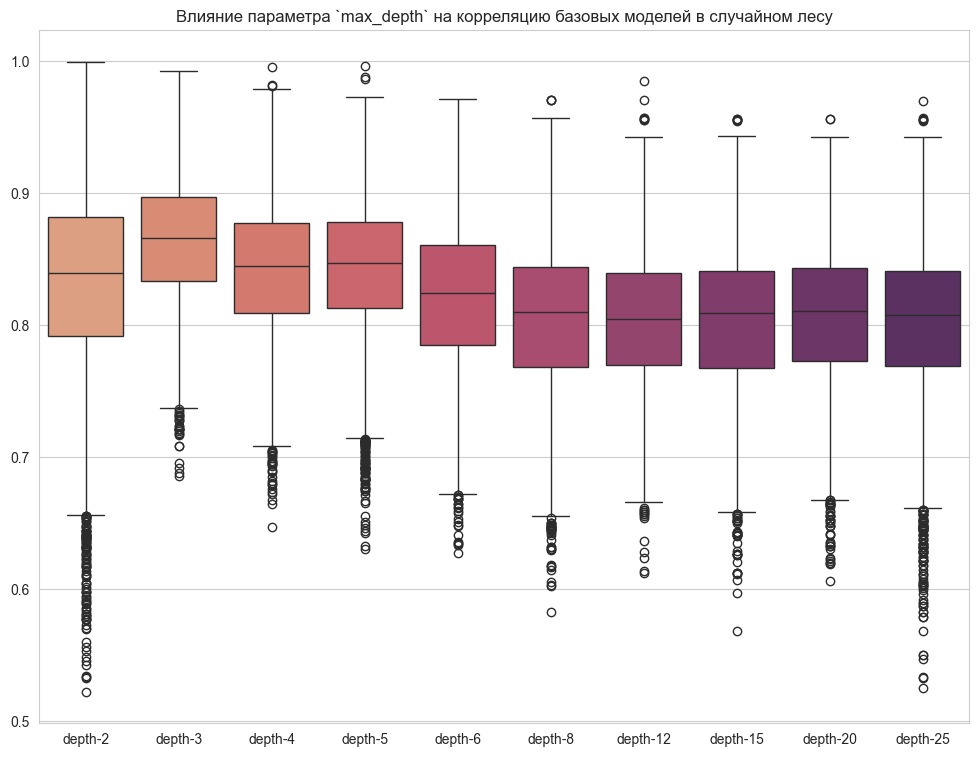

In [84]:
ax = sns.boxplot(result_corr, palette = 'flare')
label_list = ['depth-2','depth-3','depth-4','depth-5','depth-6','depth-8','depth-12','depth-15','depth-20','depth-25']
ax.set_xticklabels(label_list)
plt.title('Влияние параметра `max_depth` на корреляцию базовых моделей в случайном лесу');

Опишите ваши наблюдения:

* При увеличении количества признаков (max_feature) увеличивается корреляция между базовыми моделями в случайном лесу. При этом в какой-то момент при больших значениях max_features показатель корреляции перестает расти.
* При увеличении max_depth значения корреляции также выходят на плато. Чуть большие значения корреляции получаются при глубине 2 и 3, но не сильно. 

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [8]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../Data/heart.csv")

In [9]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2
155,58,0,0,130,197,0,1,131,0,0.6,1,0,2
117,56,1,3,120,193,0,0,162,0,1.9,1,0,3
176,60,1,0,117,230,1,1,160,1,1.4,2,2,3
130,54,0,2,160,201,0,1,163,0,0.0,2,1,2
126,47,1,0,112,204,0,1,143,0,0.1,2,0,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мягкого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [120]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [158]:
#Сделаем ансамбль
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting ='soft')
#Проверим f1
dict_for_dataframe = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: []}

for i, model in enumerate([dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]): 
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring="f1")
    dict_for_dataframe[i] = scores
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.8248316466142553
RandomForestClassifier: 0.8054592074592074
CatBoostClassifier: 0.8474173169825345
ExtraTreesClassifier: 0.8404428325297891
KNeighborsClassifier: 0.6880325793369272
SVC: 0.8681103678929766
SVC: 0.678139316400186
XGBClassifier: 0.8043896489983448
[LightGBM] [Info] Number of positive: 106, number of negative: 98
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 204, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519608 -> initscore=0.078472
[LightGBM] [Info] Start training from score 0.078472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

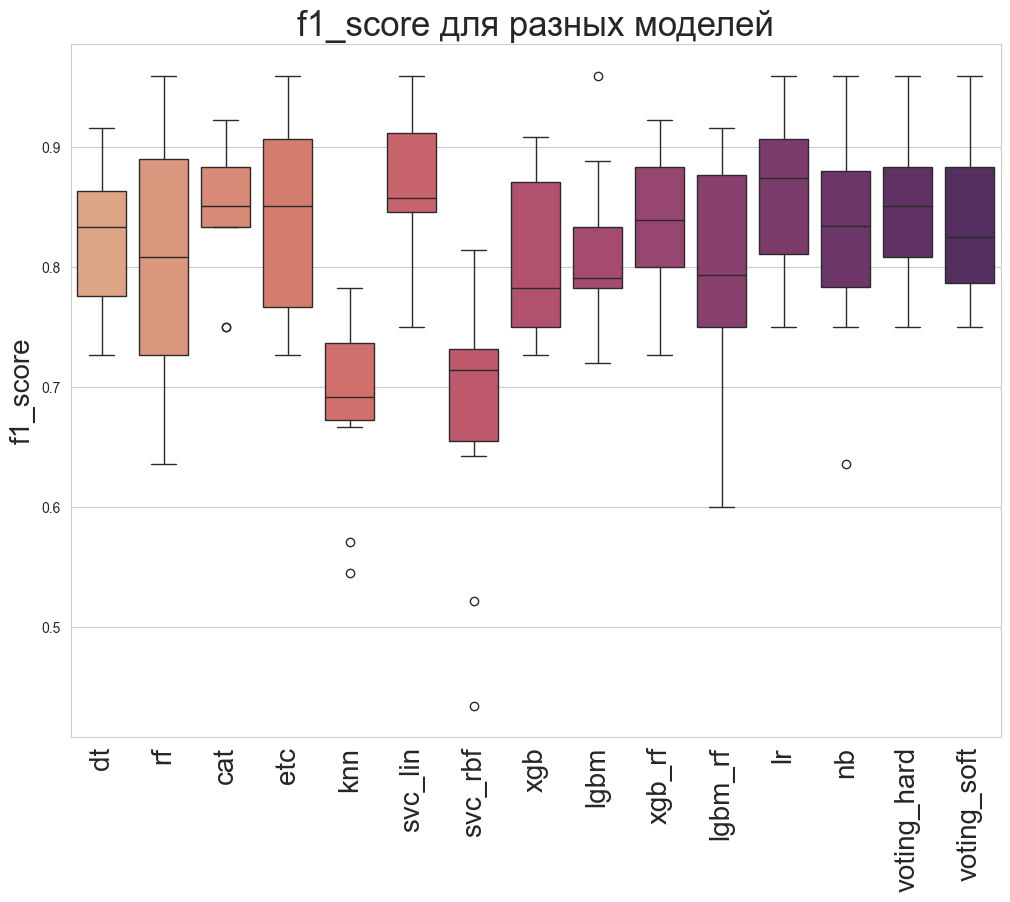

In [149]:
score_models = pd.DataFrame.from_dict(dict_for_dataframe, orient='columns')
score_models.columns = ['dt', 'rf', 'cat', 'etc', 'knn', 'svc_lin', 'svc_rbf', 'xgb', 'lgbm', 'xgb_rf', 'lgbm_rf', 'lr', 'nb', 'voting_hard', 'voting_soft']
# Сделаем для наглядности график
ax = sns.boxplot(data=score_models, palette='flare')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("f1_score", size=20)
plt.title("f1_score для разных моделей", size=25)
plt.xticks(size=20)
plt.show()

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [115]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [160]:
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(X_train, y_train)
voting_soft_corr = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

[LightGBM] [Info] Number of positive: 118, number of negative: 109
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 227, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519824 -> initscore=0.079337
[LightGBM] [Info] Start training from score 0.079337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [182]:
сorr_between_model = {}
for one_model, two_model, corr in voting_soft_corr:
    model1 = str(one_model).split('(')[0]
    model2 = str(two_model).split('(')[0]
    if 'catboost' in model1:
        model1 = 'catboost'
    if 'catboost' in model2:
        model2 = 'catboost'
    
    сorr_between_model[(model1, model2)] = corr
    
ser = pd.Series(list(сorr_between_model.values()),
                  index=pd.MultiIndex.from_tuples(сorr_between_model.keys()))
df = ser.unstack().fillna(0)    
#Успех, мы сумели засунуть кучу значений корреляции между моделями в датафрейм, теперь построим heatmap

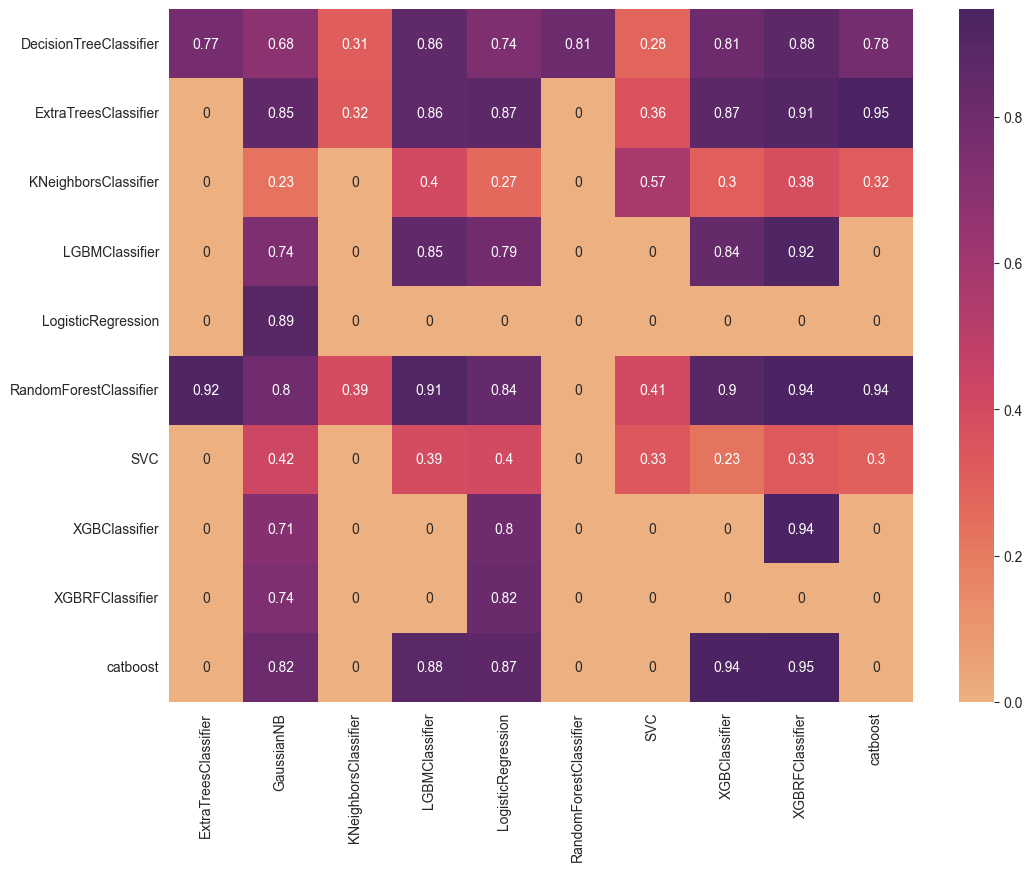

In [189]:
sns.heatmap(df, annot=True, cmap = 'flare');

<span style='color: green;'>Видно, что Decision Tree и Random Forest сильно коррелирует с другими моделями. Для начала дропнем Decision Tree.</span>

In [194]:
base_models = [("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting ='soft')
score_voting_hard = cross_val_score(voting_hard, X_train, y_train, cv=5, scoring="f1")
score_voting_soft = cross_val_score(voting_soft, X_train, y_train, cv=5, scoring="f1")

print(f'\nf1 score для voting_hard {score_voting_hard.mean()} ')
print(f'f1 score для voting_hard {score_voting_soft.mean()}')

[LightGBM] [Info] Number of positive: 94, number of negative: 87
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 181, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519337 -> initscore=0.077387
[LightGBM] [Info] Start training from score 0.077387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

<span style='color: green;'> Что ж, модель стала не сильно лучше. f1_ score = 0.845</span>

<span style='color: green;'> Подберем гиперпараметры для некоторых моделей прежде чем смотреть лучшие комбинации</span>

In [11]:
#Подберем параметры для RandomForest
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [12]:
print(f" F1_score для RandomForest : {cross_val_score(RandomForestClassifier(n_estimators=500, max_depth = 6, max_features = 'sqrt', random_state=SEED), X_train, y_train, cv=10, scoring='f1').mean()}")

 F1_score для RandomForest : 0.8422207357859532


<span style='color: green;'>F1_score для модели с подобранными гиперпарараметрами стал выше чем был при дефолтных!</span>

In [211]:
#Подберем параметры для knn
param_grid = { 
    'n_neighbors': [i for i in range(2,10)], 
}

CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 5)
CV_knn.fit(X_train, y_train)
CV_knn.best_params_

{'n_neighbors': 7}

In [23]:
def objective(trial):
    """
    Objective function to be optimized.
    """
    param = {
        'penalty' : trial.suggest_categorical('penalty', ["l2"]),
        'solver' : trial.suggest_categorical("solver", ["liblinear", "saga", "lbfgs", "newton-cg"]),
    }
    cv = KFold(n_splits=5)
    log_model = LogisticRegression(n_jobs=8, **param)
    cv_res_log_model = cross_validate(log_model,
                                      X,
                                      y,
                                      cv=cv,
                                      scoring="f1")
    
    scores = cv_res_log_model["test_score"]
    
    return scores.mean()

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=8)
study.best_params

In [232]:
print(f" F1_score для логистической регрессии : {cross_val_score(LogisticRegression(solver='lbfgs', penalty = 'l2', max_iter=10000), X_train, y_train, cv=5, scoring='f1').mean()}")
#F1_score с подобранными гиперпарараметрами стал выше чем был!

 F1_score для логистической регрессии : 0.8482385730211817


In [138]:
#Создадим модели
rf = RandomForestClassifier(n_estimators=50, max_depth = 6, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=7, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED, verbose= -1)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED, verbose= -1)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='lbfgs', penalty = 'l2', max_iter=10000)
nb = GaussianNB()

base_models = [("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

In [90]:
ids_base_models = list(range(0, len(base_models)))
#Сделаем комбинации по 3 и по 6 (И будем надеяться, что это не будет считаться 10 часов)
combinations_model3_6 = []
for n in [3, 4, 5, 6]:
    combinations_model3_6.append(list(itertools.combinations(ids_base_models,n)))
print(f'Количество комбинаций : {len(list(itertools.chain.from_iterable(combinations_model3_6)))}')

Количество комбинаций : 2431


In [91]:
#Это лучше заново не запускать
# best_comb = []
# for models in tqdm(list(itertools.chain.from_iterable(combinations_model3_6))):
#     model_for_ensembles = [base_models[i] for i in models]
#     voting_hard = VotingClassifier(estimators=model_for_ensembles, voting='hard')
#     voting_soft = VotingClassifier(estimators=model_for_ensembles, voting ='soft')
# 
#     scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=5, scoring="f1").mean()
#     scores_soft  = cross_val_score(voting_soft, X_train, y_train, cv=5, scoring="f1").mean()
#     if any((scores_hard > 0.86, scores_soft > 0.86)):
#         best_comb.append(models)

100%|██████████| 2431/2431 [5:47:23<00:00,  8.57s/it]  


Спустя 5 часов 47 минут мы обучили 2431 модель и нашли 64 моделей с f1_score > 0.86

In [141]:
best_comb2 = []
for models in tqdm(list(best_comb)):
    model_for_ensembles = [base_models[i] for i in models]
    voting_hard = VotingClassifier(estimators=model_for_ensembles, voting='hard')
    voting_soft = VotingClassifier(estimators=model_for_ensembles, voting ='soft')

    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=5, scoring="f1").mean()
    scores_soft  = cross_val_score(voting_soft, X_train, y_train, cv=5, scoring="f1").mean()
    if any((scores_hard > 0.87, scores_soft > 0.87)):
        best_comb2.append(models)

100%|██████████| 64/64 [10:17<00:00,  9.65s/it]


In [145]:
#Посмотрим f1_score для лучших комбинаций моделей
for models in tqdm(list(best_comb2)):
    model_for_ensembles = [base_models[i] for i in models]
    voting_hard = VotingClassifier(estimators=model_for_ensembles, voting='hard')
    voting_soft = VotingClassifier(estimators=model_for_ensembles, voting ='soft')
    voting_hard.fit(X_train, y_train)
    voting_soft.fit(X_train, y_train)
    
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=5, scoring="f1")
    scores_soft  = cross_val_score(voting_soft, X_train, y_train, cv=5, scoring="f1")

    y_pred_soft = voting_soft.predict(X_test)
    f1_soft = f1_score(y_test, y_pred_soft)

    y_pred_hard = voting_hard.predict(X_test)
    f1_hard  = f1_score(y_test, y_pred_hard)

    print(f'f1_score_cv - voting_hard = {scores_hard.mean()}, voting_soft_cv = {scores_soft.mean()}\n'
          f'f1_score - voting_hard = {f1_hard}, voting_soft = {f1_soft}\n {"---------" * 5}')

 20%|██        | 1/5 [00:11<00:45, 11.27s/it]

f1_score_cv - voting_hard = 0.8740925087983911, voting_soft_cv = 0.8490973432851401
f1_score - voting_hard = 0.8910891089108911, voting_soft = 0.8737864077669902
 ---------------------------------------------


 40%|████      | 2/5 [00:22<00:33, 11.26s/it]

f1_score_cv - voting_hard = 0.8707105035140078, voting_soft_cv = 0.8481736507311954
f1_score - voting_hard = 0.8823529411764706, voting_soft = 0.8712871287128713
 ---------------------------------------------


 60%|██████    | 3/5 [00:44<00:31, 15.99s/it]

f1_score_cv - voting_hard = 0.8705609136736456, voting_soft_cv = 0.8421200237670826
f1_score - voting_hard = 0.8543689320388349, voting_soft = 0.86
 ---------------------------------------------


 80%|████████  | 4/5 [00:51<00:12, 12.76s/it]

f1_score_cv - voting_hard = 0.8723770444632702, voting_soft_cv = 0.8466964260881656
f1_score - voting_hard = 0.8910891089108911, voting_soft = 0.8737864077669902
 ---------------------------------------------


100%|██████████| 5/5 [01:10<00:00, 14.01s/it]

f1_score_cv - voting_hard = 0.8709977653373879, voting_soft_cv = 0.8481906237672373
f1_score - voting_hard = 0.8910891089108911, voting_soft = 0.8737864077669902
 ---------------------------------------------


<span style='color: green;'>Печально! Метрики у подобранных моделей выше чем, когда мы брали по дефолту все, но хотелось получить еще выше! 
Лучшая метрика получилась при сочетании: RF, ETC, KNN, SVC_LIN, LR (f1_score(cv) - 0.874, f1_score - 0.89)</span>

In [154]:
#Посмотрим на комбинации моделей по 2
combinations_model2 = []
combinations_model2.append(list(itertools.combinations(ids_base_models,2)))
print(f'Количество комбинаций : {len(list(itertools.chain.from_iterable(combinations_model2)))}')

Количество комбинаций : 66


In [155]:
best_comb_3= []
for models in tqdm(list(itertools.chain.from_iterable(combinations_model2))):
    model_for_ensembles = [base_models[i] for i in models]
    voting_hard = VotingClassifier(estimators=model_for_ensembles, voting='hard')
    voting_soft = VotingClassifier(estimators=model_for_ensembles, voting ='soft')
    
    voting_hard.fit(X_train, y_train)
    voting_soft.fit(X_train, y_train)
    
    y_pred_soft = voting_soft.predict(X_test)
    f1_soft = f1_score(y_test, y_pred_soft)

    y_pred_hard = voting_hard.predict(X_test)
    f1_hard  = f1_score(y_test, y_pred_hard)
    
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=5, scoring="f1").mean()
    scores_soft  = cross_val_score(voting_soft, X_train, y_train, cv=5, scoring="f1").mean()

    if any((scores_hard > 0.87, scores_soft > 0.87, f1_soft > 0.87, f1_hard > 0.87)):
        best_comb_3.append(models)

100%|██████████| 66/66 [04:25<00:00,  4.02s/it]


<span style='color: green;'>Как-то много моделей (39) получилось с f1_score > 0.87, поэтому еще раз пофильтруем</span>

In [161]:
best_comb_4= []
for models in tqdm(best_comb_3):
    model_for_ensembles = [base_models[i] for i in models]
    voting_hard = VotingClassifier(estimators=model_for_ensembles, voting='hard')
    voting_soft = VotingClassifier(estimators=model_for_ensembles, voting ='soft')
    
    voting_hard.fit(X_train, y_train)
    voting_soft.fit(X_train, y_train)
    
    y_pred_soft = voting_soft.predict(X_test)
    f1_soft = f1_score(y_test, y_pred_soft)

    y_pred_hard = voting_hard.predict(X_test)
    f1_hard  = f1_score(y_test, y_pred_hard)
    
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=5, scoring="f1").mean()
    scores_soft  = cross_val_score(voting_soft, X_train, y_train, cv=5, scoring="f1").mean()

    if any((scores_hard > 0.89, scores_soft > 0.89, f1_soft > 0.89, f1_hard > 0.89)):
        best_comb_4.append(models)
    

100%|██████████| 39/39 [03:30<00:00,  5.39s/it]


In [169]:
#Посмотрим f1_score для лучших комбинаций моделей
for models in tqdm(best_comb_4):
    model_for_ensembles = [base_models[i] for i in models]
    voting_hard = VotingClassifier(estimators=model_for_ensembles, voting='hard')
    voting_soft = VotingClassifier(estimators=model_for_ensembles, voting ='soft')
    voting_hard.fit(X_train, y_train)
    voting_soft.fit(X_train, y_train)
    
    scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=5, scoring="f1")
    scores_soft  = cross_val_score(voting_soft, X_train, y_train, cv=5, scoring="f1")

    y_pred_soft = voting_soft.predict(X_test)
    f1_soft = f1_score(y_test, y_pred_soft)

    y_pred_hard = voting_hard.predict(X_test)
    f1_hard  = f1_score(y_test, y_pred_hard)

    print(f'{model_for_ensembles}\n'
          f'f1_score_cv - voting_hard = {scores_hard.mean()}, voting_soft_cv = {scores_soft.mean()}\n'
          f'f1_score - voting_hard = {f1_hard}, voting_soft = {f1_soft}\n {"---------" * 5}')

  7%|▋         | 1/14 [00:04<00:55,  4.23s/it]

[('RF', RandomForestClassifier(max_depth=6, n_estimators=500, random_state=111)), ('NB', GaussianNB())]
f1_score_cv - voting_hard = 0.8204218416652251, voting_soft_cv = 0.8350673151349775
f1_score - voting_hard = 0.9052631578947369, voting_soft = 0.9072164948453608
 ---------------------------------------------


 14%|█▍        | 2/14 [00:05<00:28,  2.39s/it]

[('ETC', ExtraTreesClassifier(random_state=111)), ('LR', LogisticRegression(max_iter=10000))]
f1_score_cv - voting_hard = 0.8151123239993672, voting_soft_cv = 0.8480583002431741
f1_score - voting_hard = 0.8936170212765957, voting_soft = 0.8712871287128713
 ---------------------------------------------


 21%|██▏       | 3/14 [00:06<00:17,  1.61s/it]

[('ETC', ExtraTreesClassifier(random_state=111)), ('NB', GaussianNB())]
f1_score_cv - voting_hard = 0.7979296637012053, voting_soft_cv = 0.8238041342140721
f1_score - voting_hard = 0.8936170212765957, voting_soft = 0.9072164948453608
 ---------------------------------------------


 29%|██▊       | 4/14 [00:12<00:33,  3.38s/it]

[('SVC_LIN', SVC(kernel='linear', probability=True, random_state=111)), ('NB', GaussianNB())]
f1_score_cv - voting_hard = 0.8245266073747024, voting_soft_cv = 0.8298979971682845
f1_score - voting_hard = 0.9052631578947369, voting_soft = 0.9072164948453608
 ---------------------------------------------


 36%|███▌      | 5/14 [00:24<00:58,  6.50s/it]

[('CAT', <catboost.core.CatBoostClassifier object at 0x000001E699A51C90>), ('XGB_RF', XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=111, reg_alpha=None, ...))]
f1_score_cv - voting_hard = 0.8115634442042452, voting_soft_cv = 0.8385958435876402
f1_score - voting_hard = 0.8686

 43%|████▎     | 6/14 [00:36<01:06,  8.35s/it]

[('CAT', <catboost.core.CatBoostClassifier object at 0x000001E699A51C90>), ('LR', LogisticRegression(max_iter=10000))]
f1_score_cv - voting_hard = 0.8282477289117859, voting_soft_cv = 0.856058855620808
f1_score - voting_hard = 0.8979591836734694, voting_soft = 0.8712871287128713
 ---------------------------------------------


 50%|█████     | 7/14 [00:47<01:05,  9.41s/it]

[('CAT', <catboost.core.CatBoostClassifier object at 0x000001E699A51C90>), ('NB', GaussianNB())]
f1_score_cv - voting_hard = 0.8109700750812125, voting_soft_cv = 0.8465641025641025
f1_score - voting_hard = 0.9263157894736842, voting_soft = 0.9072164948453608
 ---------------------------------------------


 57%|█████▋    | 8/14 [00:47<00:38,  6.49s/it]

[('LGBM', LGBMClassifier(random_state=111, verbose=-1)), ('NB', GaussianNB())]
f1_score_cv - voting_hard = 0.7896453226759401, voting_soft_cv = 0.819409971346398
f1_score - voting_hard = 0.9148936170212766, voting_soft = 0.88
 ---------------------------------------------


 71%|███████▏  | 10/14 [00:48<00:13,  3.26s/it]

[('LGBM_RF', LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',
               random_state=111, verbose=-1)), ('LR', LogisticRegression(max_iter=10000))]
f1_score_cv - voting_hard = 0.795918520347728, voting_soft_cv = 0.8298554797270172
f1_score - voting_hard = 0.8958333333333334, voting_soft = 0.8543689320388349
 ---------------------------------------------
[('LGBM_RF', LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',
               random_state=111, verbose=-1)), ('NB', GaussianNB())]
f1_score_cv - voting_hard = 0.7805906359458852, voting_soft_cv = 0.8298974358974359
f1_score - voting_hard = 0.9247311827956989, voting_soft = 0.8979591836734694
 ---------------------------------------------


 79%|███████▊  | 11/14 [00:49<00:07,  2.37s/it]

[('XGB', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=111, ...)), ('NB', GaussianNB())]
f1_score_cv - voting_hard = 0.7901362332365371, voting_soft_cv = 0.8399308659634066
f1_score - voting_hard = 0.9032258064516129, voting_soft = 0.8712871287128713
 ---------------------------------------------


 86%|████████▌ | 12/14 [00:49<00:03,  1.90s/it]

[('XGB_RF', XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=111, reg_alpha=None, ...)), ('LR', LogisticRegression(max_iter=10000))]
f1_score_cv - voting_hard = 0.8008206835223163, voting_soft_cv = 0.8401749118476916
f1_score - voting_hard = 0.8842105263157894, voting_soft = 0.

 93%|█████████▎| 13/14 [00:50<00:01,  1.45s/it]

[('XGB_RF', XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=111, reg_alpha=None, ...)), ('NB', GaussianNB())]
f1_score_cv - voting_hard = 0.7903943173593228, voting_soft_cv = 0.8366600279334676
f1_score - voting_hard = 0.9130434782608695, voting_soft = 0.8888888888888888
 ----

100%|██████████| 14/14 [00:50<00:00,  3.62s/it]

[('LR', LogisticRegression(max_iter=10000)), ('NB', GaussianNB())]
f1_score_cv - voting_hard = 0.8227943527012712, voting_soft_cv = 0.8335502013514435
f1_score - voting_hard = 0.9166666666666666, voting_soft = 0.9072164948453608
 ---------------------------------------------


<span style='color: green;'>Можно увидеть, чть есть модели с высоким f1_score  - например, LGBM_RF и NB (0.924), LR и NB (0.916), CAT и NB (0.926). Но при cross validation эти значения намного ниже! Соответственно эти модели нестабильно хорошо предсказывают значения.
Итог - лучшая метрика получилась с иcпользованием кросс валидации и моделей: RF, ETC, KNN, SVC_LIN, LR (f1_score(cv) - 0.874)</span>

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [3]:
data = pd.read_csv("../Data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [4]:
#Проверим пропущенные значения
np.sum(data.isna(), axis = 0)

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [5]:
#Уберем колонку Phone
data = data.drop(columns = 'Phone')

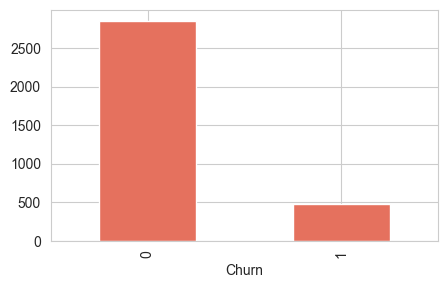

In [6]:
#Почему-то последний столбец Churn? какой-то кривой, уберем точку в конце слов
data['Churn?'] = data['Churn?'].replace('False.', 0)
data['Churn?'] = data['Churn?'].replace('True.', 1)
data = data.rename(columns={'Churn?': 'Churn'})
#Сразу же посмотрим на баланс классов
plt.figure(figsize=(5,3))
data['Churn'].value_counts().plot(kind='bar', color=sns.color_palette("flare", n_colors=3)[0]);
#Видим, что класса False в несколько раз больше чем True (Это неприятно, дальше решим, что с этим делать)

<span style='color: green;'>Для начала посмотрим на признаки и поймем, что для нас важно, а что нет. И как мы можем закодировать категориальные признаки.</span>

In [7]:
#Похоже что Area Code - это какой-то категоральный признак, переведем его в category
data['Area Code'].value_counts()
data['Area Code'] = data['Area Code'].astype('category')

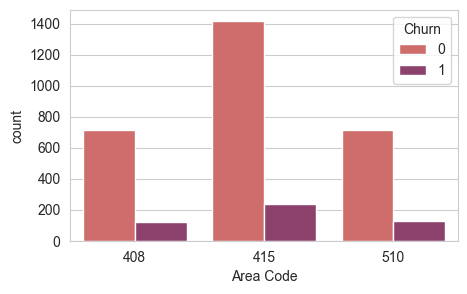

In [8]:
#Посмотрим как она связана с переменной Churn
plt.figure(figsize=(5,3))
sns.countplot(x="Area Code", hue="Churn", data=data, palette=sns.color_palette("flare", n_colors=2));

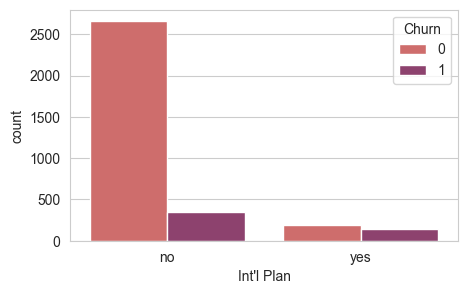

In [9]:
plt.figure(figsize=(5,3))
sns.countplot(x="Int'l Plan", hue="Churn", data=data, palette=sns.color_palette("flare", n_colors=2))
data["Int'l Plan"] = data["Int'l Plan"].astype('category');
#Видим, что при "no" значений целевой переменной False больше (возможно этот признак может быть значимым)

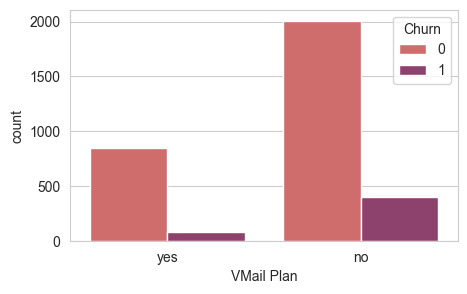

In [10]:
plt.figure(figsize=(5,3))
sns.countplot(x="VMail Plan", hue="Churn", data=data, palette=sns.color_palette("flare", n_colors=2))
data["VMail Plan"] = data["VMail Plan"].astype('category');
#При значении VMail Plan - 'yes' уменьшается количество False и увеличивается True, а для 'no' наоборот. Может быть неплохим признаком.

In [11]:
pd.crosstab(data['Day Mins'], data["Churn"]).T

Day Mins,0.0,2.6,7.8,7.9,12.5,17.6,18.9,19.5,25.9,27.0,...,326.5,328.1,329.8,332.9,334.3,335.5,337.4,345.3,346.8,350.8
Churn,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [12]:
#Самое сложное, нужна ли нам переменная 'State'. На первый взгляд нет! Очень много признаков! Но может быть ее можно засунуть catboost.CatBoostClassifier

In [13]:
pd.crosstab(data['State'], data["Churn"]).T
data['State'] = data["State"].astype('category')

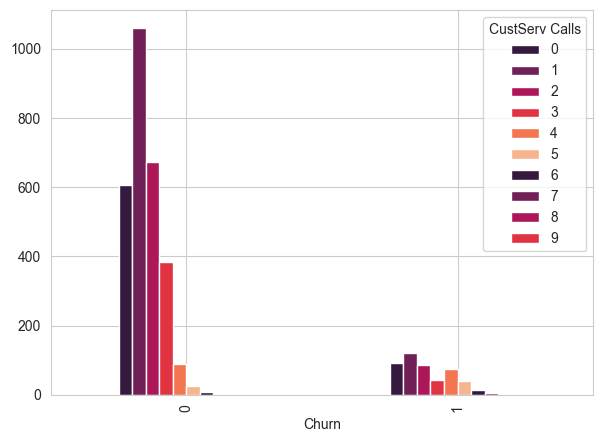

In [14]:
pd.crosstab(data['CustServ Calls'], data["Churn"]).T.plot(kind='bar', figsize=(7,5), color=sns.color_palette("rocket"));
data['CustServ Calls'] = data['CustServ Calls'].astype('category')
#В целом, что для False, что для True данные распределяются относительно значений CustServ Calls одинаково. 

In [15]:
#Посмотрим на описательные статистики для численных переменных
data.describe()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,Churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,0.144914
std,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,0.352067
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,0.000000
50%,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,0.000000
75%,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,0.000000
max,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,1.000000


In [16]:
numeric_column = data.select_dtypes('number').columns
cat_column = data.select_dtypes('category').columns
print(f"Количество числовых колонок: {len(numeric_column)}")
print(f"Количество категориальных колонок: {len(cat_column)}")

Количество числовых колонок: 15
Количество категориальных колонок: 5


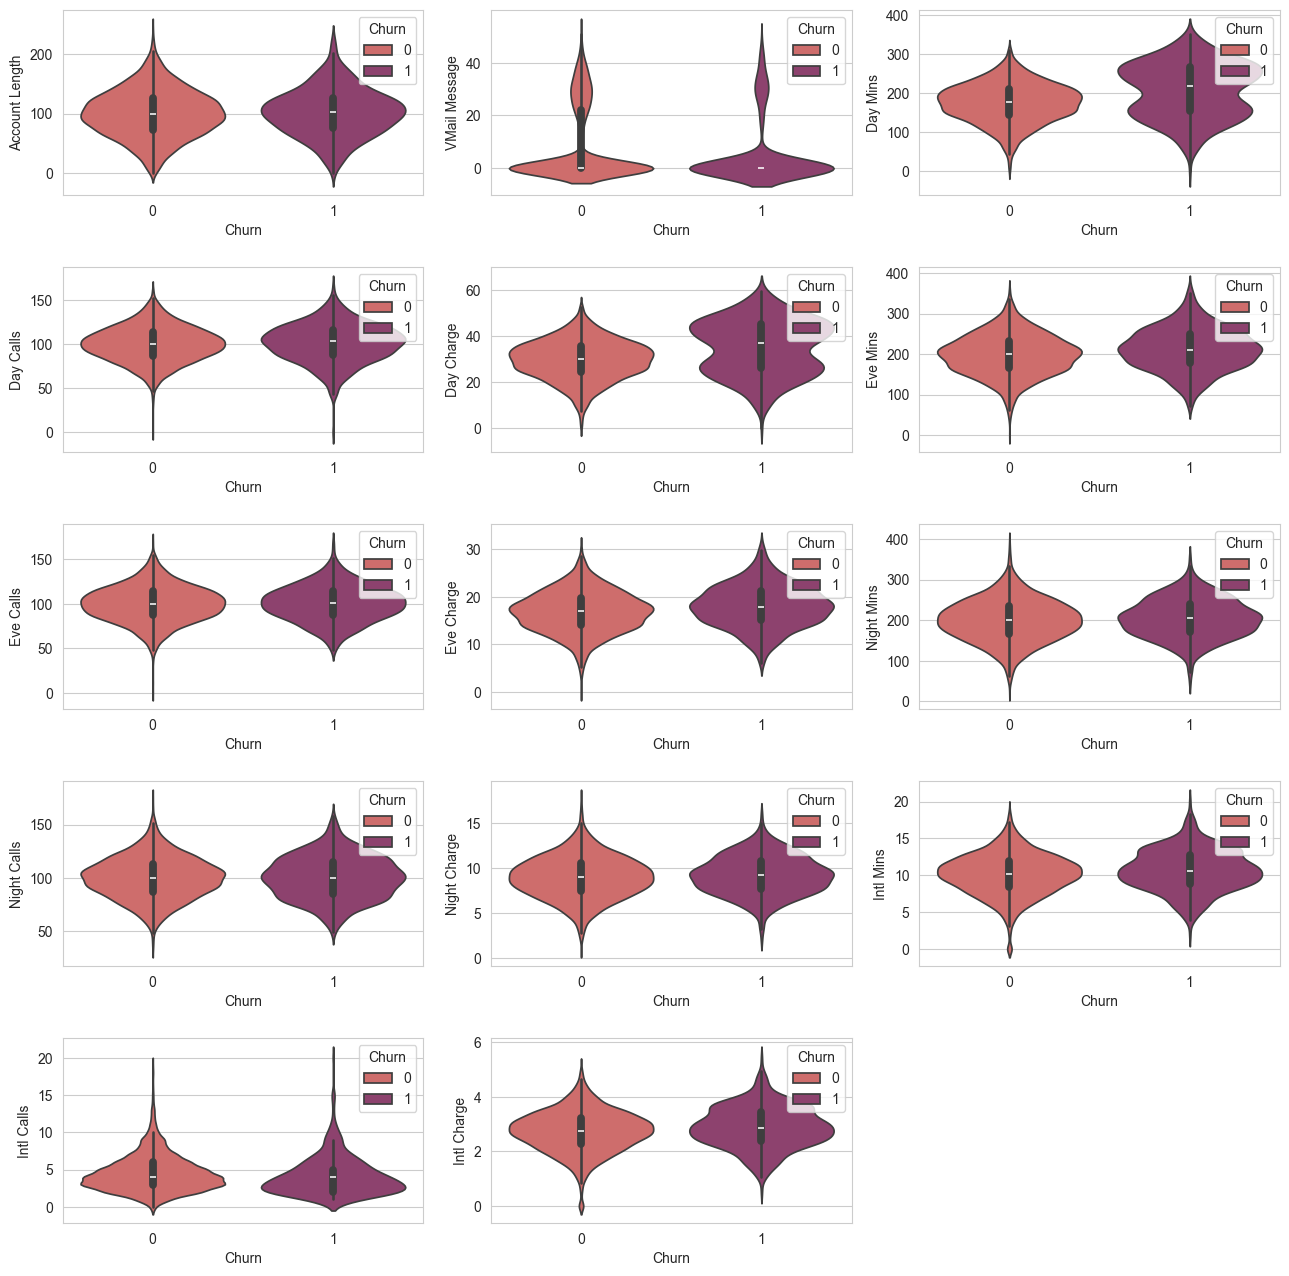

In [17]:
plt.figure(figsize=(13,15))
#Теперь давайте посмотрим на распределение данных в численных колонках относительно колонки Churn
for i, col in enumerate(numeric_column[:-1]):
    plt.subplot(6,3,i + 1)
    sns.violinplot(data,  x = 'Churn', y = col, hue='Churn', color = sns.set_palette('flare', n_colors = 2))
    plt.tight_layout(h_pad = 2)
#В целом по данным не можем сказать, что есть признак у которого распределения для состояния False и True сильно отличаются. Но можем заметить переменную Vmail Message для которой есть высокие значения при Churn = True. Также можем заметить отличия между True и False в распределениях Day Mins, Day Charge

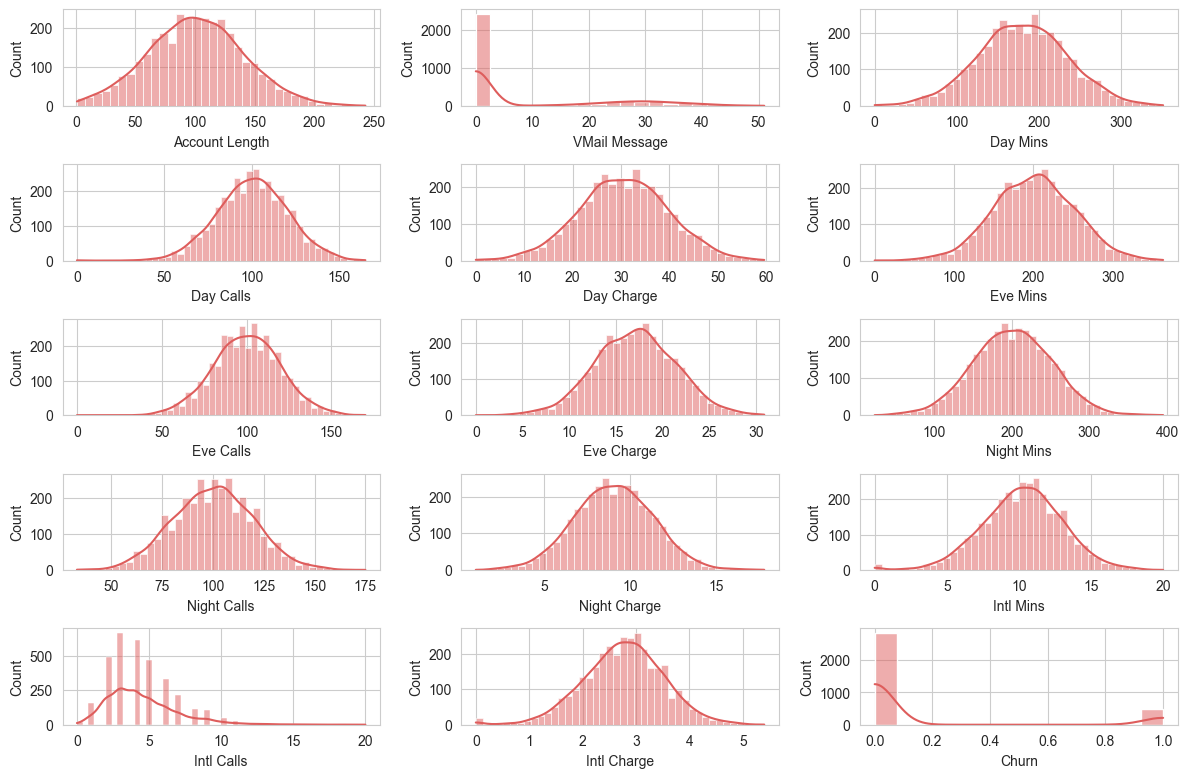

In [18]:
#Теперь посмотрим на корреляции между переменными, чтобы убрать мультиколлинеарность признаков в дальнейщем
#Для выбора метрики посмотрим на распределение переменных
i = 1
for col in numeric_column:
  plt.subplot(6, 3, i)
  sns.histplot(data[col], color = sns.set_palette('flare', n_colors = 2), kde=True)
  i += 1

plt.tight_layout();

#По графикам данные похожи на нормально распределенные (за исключением Vmail Message)

In [19]:
#Посмотрим на VMail Message, в целом кажется что эта переменная будет бесполезна. Большое значение 0 и нет особой зависимости относительно Churn True и False.
pd.crosstab(data['VMail Message'], data["Churn"]).T

VMail Message,0,4,8,9,10,11,12,13,14,15,...,42,43,44,45,46,47,48,49,50,51
Churn,,,,,,,,,,,,,,,,,,,,,
0,2008,1,2,2,1,2,6,4,7,8,...,11,9,5,5,4,3,1,1,2,1
1,403,0,0,0,0,0,0,0,0,1,...,4,0,2,1,0,0,1,0,0,0


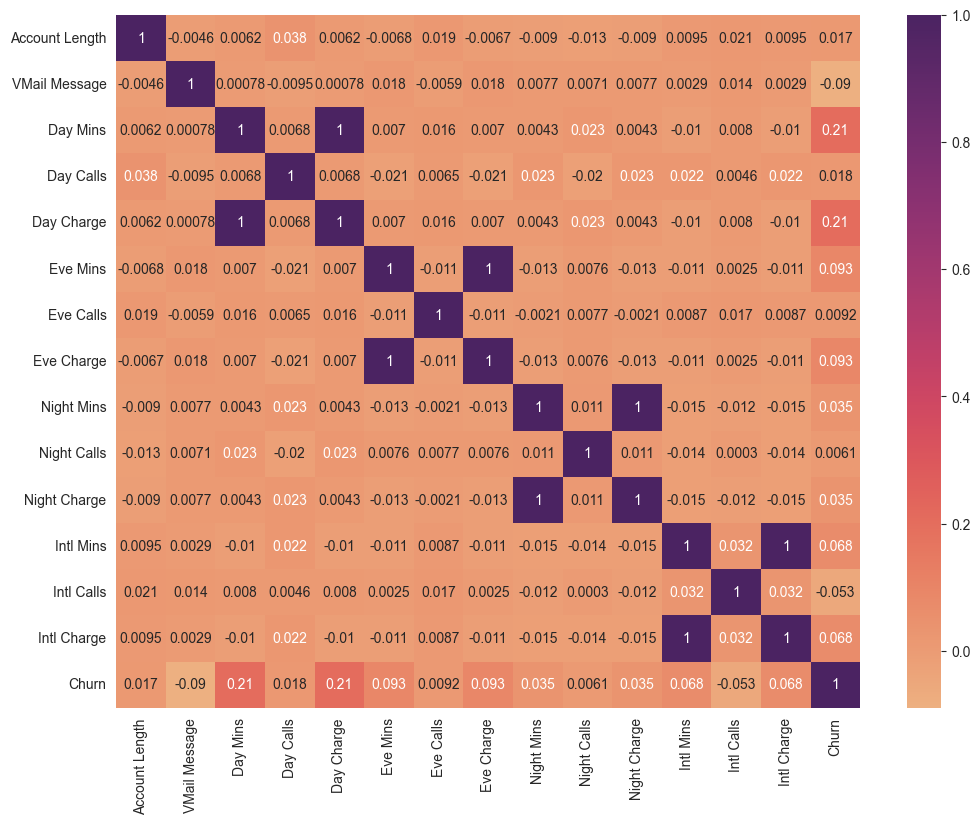

In [20]:
#Поскольку данные распределены нормально будем использовать корреляцию Пирсона. Постром heatmap для визуализации
sns.heatmap(data[numeric_column].corr(method="pearson"), annot=True, cmap="flare");

In [21]:
#Видим, что есть переменные, которые сильно коррелируют. А именно: Day Charge и Day Mins, Eve Mins и Eve Charge, Night Mins и Night Charge, Intl Mins и Intl Charge. Следовательно можем брать либо Mins либо Charge.
#Удалим переменные с корреляцией Day Charge, Eve Charge, Night Charge, Intl Charge.
data_filtr_cat = data.drop(columns = ['Day Charge', 'Eve Charge', 'Night Charge', "Intl Charge"]) #Здесь оставим переменную State (Попробуем дать это catboost)
data_filtr_cat.head()

,State,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn
0,KS,128,415,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,OH,107,415,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,NJ,137,415,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,OH,84,408,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,OK,75,415,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


In [22]:
data_filtr = data_filtr_cat.drop(columns = 'State') 
data_filtr.head()

,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,Churn
0,128,415,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,0
1,107,415,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,0
2,137,415,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,0
3,84,408,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,0
4,75,415,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,0


In [23]:
#Теперь будем проверять модели!
#Будем работать с данными data_filtr
#Сначала сделаем модель lightgbm.LGBMClassifier
#Для начала сделаем базовую модель, потом попробуем подобрать гиперпараметры.

In [24]:
#Разделим данные на тестовую и тренировочную выборки
y = data_filtr['Churn']
X = data_filtr.drop(columns = 'Churn')
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30,
                                                    random_state=SEED, stratify=y)

In [25]:
#Сделаем трансформатор для данных
category_columns = X.select_dtypes('category').columns
numeric_columns = X.select_dtypes('number').columns
#Будем использовать OneHotEncoder для категориальных столбцов и StandardScaler для числовых
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), numeric_columns),
    ("ohe", OneHotEncoder(), category_columns)
])

In [26]:
preprocessor

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 Index(['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Eve Mins',
       'Eve Calls', 'Night Mins', 'Night Calls', 'Intl Mins', 'Intl Calls'],
      dtype='object')),
                                ('ohe', OneHotEncoder(),
                                 Index(['Area Code', 'Int'l Plan', 'VMail Plan', 'CustServ Calls'], dtype='object'))])

#### Попробуем lightgbm.LGBMClassifier

In [27]:
#Сделаем пайплайн
model_lgbm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("LGBM", lightgbm.LGBMClassifier(verbose = -1))
])

In [28]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_res_lgb_model = cross_validate(model_lgbm_pipeline,
                                      X,y,
                                      cv=cv,
                                      scoring="matthews_corrcoef")
print(f"Matthews_corrcoef: {cv_res_lgb_model['test_score'].mean()}")

Matthews_corrcoef: 0.7775473902690755


In [29]:
#Попробуем подобрать параметры с помощью Optuna
def objective(trial):
    """
    Objective function to be optimized.
    """
    param = {
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": 0.005,
        "n_estimators": 1000,
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 64),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    
    model_lgbm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("LGBM", lightgbm.LGBMClassifier(n_jobs = 8, **param))
])

    cv_res_lgb_model = cross_validate(model_lgbm_pipeline,
                                      X,
                                      y,
                                      cv=cv,
                                      scoring="matthews_corrcoef")
    
    scores = cv_res_lgb_model["test_score"]
    return scores.mean()


In [30]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=55, n_jobs = 8)

[I 2024-03-13 17:58:45,032] A new study created in memory with name: no-name-6f4420a4-64bf-4dea-a567-1d4014fec2c7
[I 2024-03-13 17:59:21,377] Trial 0 finished with value: 0.43662178898878956 and parameters: {'reg_alpha': 0.03407605568720224, 'reg_lambda': 0.001063277152052248, 'num_leaves': 27, 'feature_fraction': 0.5585817638530904, 'bagging_fraction': 0.415868134707127, 'bagging_freq': 4, 'min_child_samples': 98}. Best is trial 0 with value: 0.43662178898878956.
[I 2024-03-13 17:59:32,203] Trial 7 finished with value: 0.3849740777846046 and parameters: {'reg_alpha': 0.0019476229079252731, 'reg_lambda': 1.102911817125618, 'num_leaves': 10, 'feature_fraction': 0.3575457551872937, 'bagging_fraction': 0.4513260738169743, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 0 with value: 0.43662178898878956.
[I 2024-03-13 17:59:38,085] Trial 4 finished with value: 0.3787282600152154 and parameters: {'reg_alpha': 0.06027928636899401, 'reg_lambda': 0.002018322793189382, 'num_leaves': 

In [31]:
print(f'Подобранные параметры для модели: {study.best_params}\n')
print(f'Лучший matthews_corrcoef для модели: {study.best_value}')
#Значение matthews_corrcoef стало выше чем при дефолтных гиперпараметрах!

Подобранные параметры для модели: {'reg_alpha': 0.00950743579512351, 'reg_lambda': 0.015063234161941528, 'num_leaves': 38, 'feature_fraction': 0.8006973498784786, 'bagging_fraction': 0.7803925192952956, 'bagging_freq': 3, 'min_child_samples': 7}

Лучший matthews_corrcoef для модели: 0.7816921784075828


Matthews_corrcoef_lightgbm = 0.7621933
Accuracy_lightgbm = 0.945


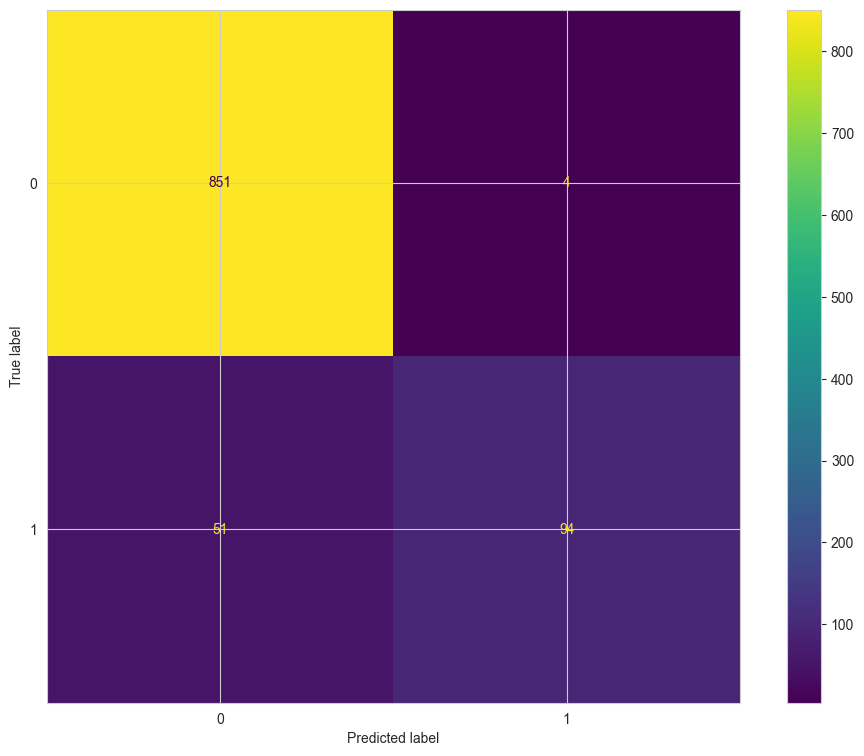

In [47]:
model_lgbm_pipeline_best = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("LGBM", lightgbm.LGBMClassifier(verbose = -1, **study.best_params))
])
#Обучим модель и предскажем значения
model_lgbm_pipeline_best.fit(X_train, y_train)
pred = model_lgbm_pipeline_best.predict(X_test)
print(f'Matthews_corrcoef_lightgbm = {round(matthews_corrcoef(y_test, pred), 7)}')
print(f'Accuracy_lightgbm = {round(accuracy_score(y_test, pred), 7)}')
ConfusionMatrixDisplay.from_predictions(y_test, pred);
#Видим, что Accuracy высокое, но мы не будем на это смотреть поскольку у нас несбалансированные данные
#Будем смотреть на Matthews_corrcoef
#По ConfusionMatrix видно, что модель предсказывает хорошо False (Что логично поскольку у нас сильный перевес в сторону False) и ошибается в True

#### Попробуем xgboost.XGBRFClassifier

In [48]:
#Сделаем пайплайн
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

model_xgboost_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgboost", xgboost.XGBRFClassifier(verbose=-1))
])


cv_res_xgboost_model = cross_validate(model_xgboost_pipeline,
                                  X,
                                  y,
                                  cv=cv,
                                  scoring="matthews_corrcoef")
print(f"Matthews_corrcoef_xgboost: {cv_res_xgboost_model['test_score'].mean()}")

Matthews_corrcoef_xgboost: 0.6977693956873844


0:	learn: 0.6209040	total: 58.6ms	remaining: 58.5s
1:	learn: 0.5649793	total: 59.7ms	remaining: 29.8s
2:	learn: 0.5149696	total: 60.6ms	remaining: 20.1s
3:	learn: 0.4796365	total: 61.6ms	remaining: 15.3s
4:	learn: 0.4504202	total: 62.5ms	remaining: 12.4s
5:	learn: 0.4272137	total: 63.4ms	remaining: 10.5s
6:	learn: 0.4072142	total: 64.3ms	remaining: 9.12s
7:	learn: 0.3892306	total: 65.1ms	remaining: 8.08s
8:	learn: 0.3756355	total: 66ms	remaining: 7.27s
9:	learn: 0.3649347	total: 66.9ms	remaining: 6.63s
10:	learn: 0.3545947	total: 67.8ms	remaining: 6.09s
11:	learn: 0.3469590	total: 68.6ms	remaining: 5.65s
12:	learn: 0.3395340	total: 69.5ms	remaining: 5.27s
13:	learn: 0.3337988	total: 70.4ms	remaining: 4.96s
14:	learn: 0.3271755	total: 71.3ms	remaining: 4.68s
15:	learn: 0.3207705	total: 72.2ms	remaining: 4.44s
16:	learn: 0.3165282	total: 73.1ms	remaining: 4.22s
17:	learn: 0.3126256	total: 74ms	remaining: 4.04s
18:	learn: 0.3099276	total: 74.9ms	remaining: 3.87s
19:	learn: 0.3056638	total

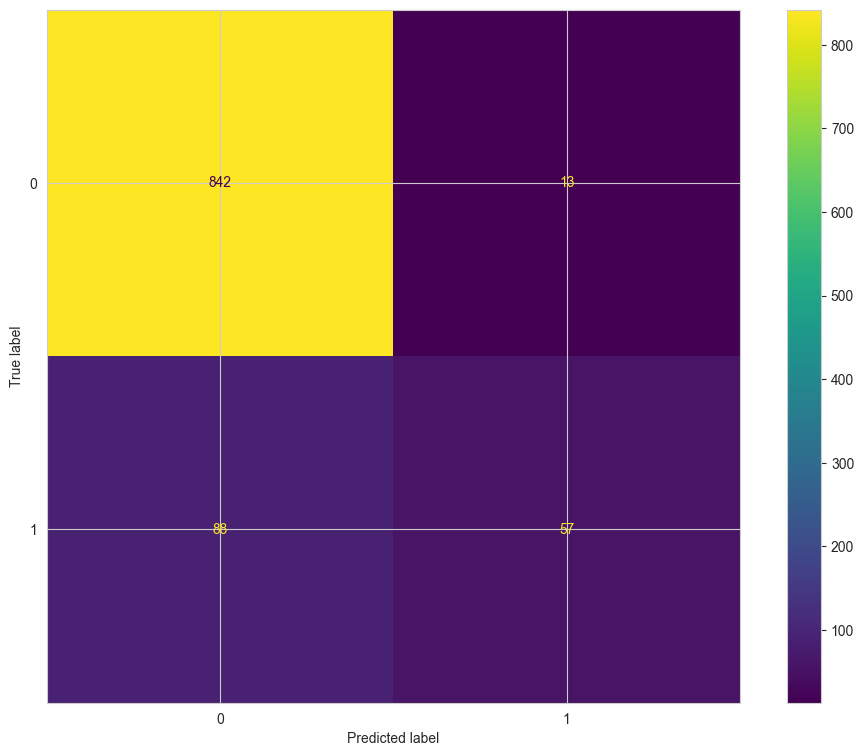

In [57]:
#Попробуем catboost
y_cat = data_filtr_cat['Churn']
X_cat  = data_filtr_cat.drop(columns = 'Churn')
X_train, X_test, y_train, y_test = train_test_split(X_cat, 
                                                    y_cat, 
                                                    test_size=0.30,
                                                    random_state=SEED, stratify=y)

preprocessor_catboost = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), numeric_columns),
])

cat_model = catboost.CatBoostClassifier(iterations=1000, 
                     learning_rate=0.1,
                     depth=6,
                     random_state=42,
                     min_data_in_leaf=7)

model_catboost_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_catboost),
    ("xgboost", cat_model)
])

#Обучим модель и предскажем значения
model_catboost_pipeline.fit(X_train, y_train)
pred = model_catboost_pipeline.predict(X_test)
print(f'Matthews_corrcoef_catboost = {round(matthews_corrcoef(y_test, pred), 3)}')
print(f'Accuracy_catboost = {round(accuracy_score(y_test, pred), 3)}')
ConfusionMatrixDisplay.from_predictions(y_test, pred);
#Похоже catboost с базовыми настройками справился хуже чем lightgbm, но наверное нужно просто поподбирать параметры

#### Попробуем избавиться от дисбаланса классов

In [61]:
# Создание экземпляра RandomOverSampler
ros = RandomOverSampler()

# Применение увеличиваем количство образцов меньшего класса
X_balance, y_balance = ros.fit_resample(X, y)
y_balance.value_counts()

Churn
0    2850
1    2850
Name: count, dtype: int64

In [64]:
#Сделаем train и test выборки
X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance, test_size=0.30, random_state=SEED)

Matthews_corrcoef_lgbm = 0.977
f1_score_lgbm = 0.988
roc_auc_lgbm = 0.988
Matthews_corrcoef_xgboost = 0.801
f1_score_xgboost = 0.897
roc_auc_xgboost = 0.898


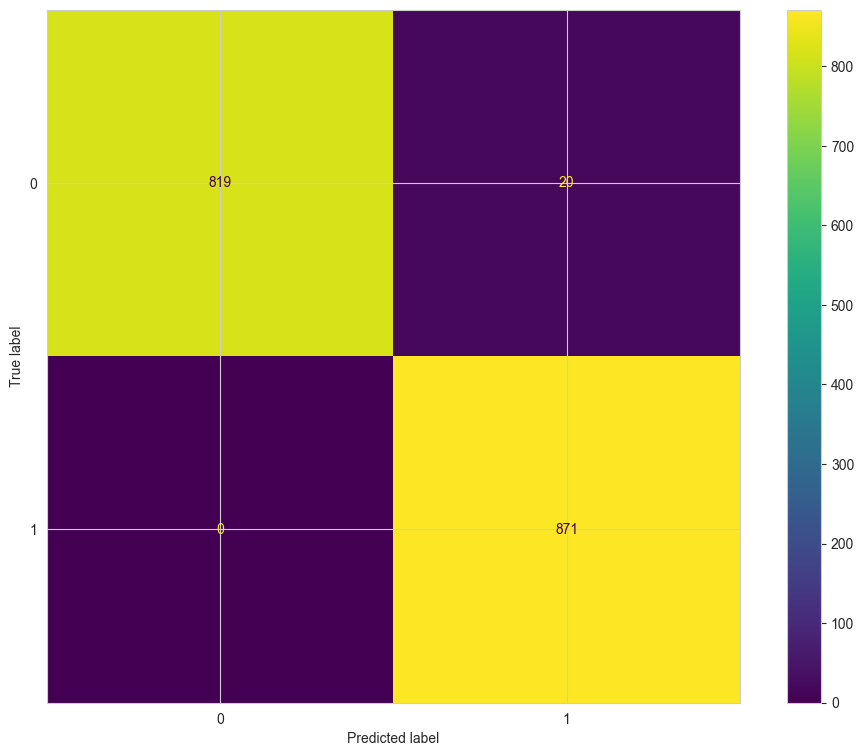

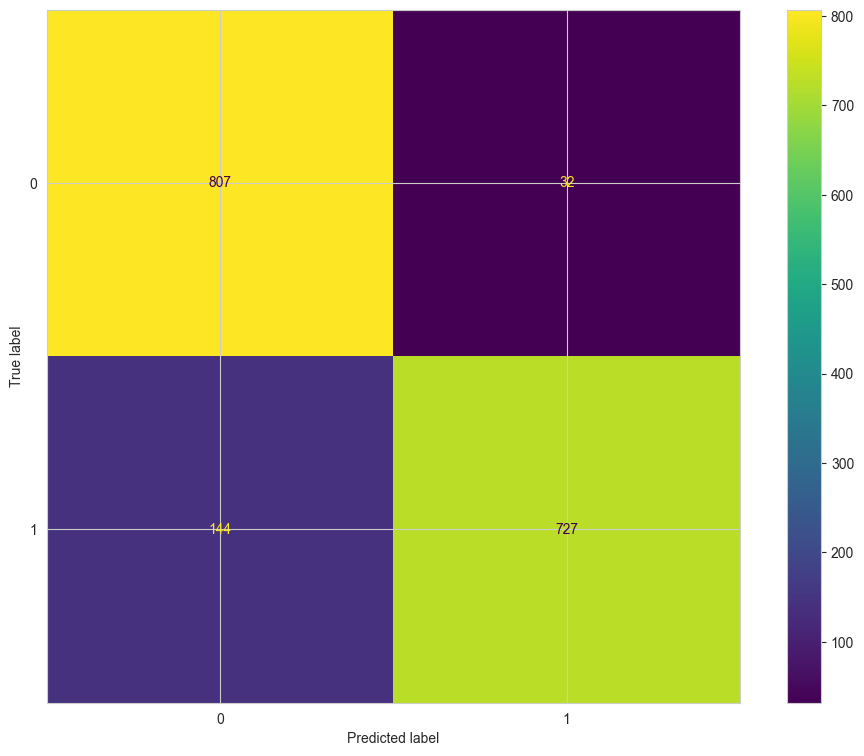

In [68]:
#Обучим модель lgbm и предскажем значения
model_lgbm_pipeline_best.fit(X_train, y_train)
pred = model_lgbm_pipeline_best.predict(X_test)
print(f'Matthews_corrcoef_lgbm = {round(matthews_corrcoef(y_test, pred), 3)}')
print(f'f1_score_lgbm = {round(accuracy_score(y_test, pred), 3)}')
print(f'roc_auc_lgbm = {round(roc_auc_score(y_test, pred), 3)}')
ConfusionMatrixDisplay.from_predictions(y_test, pred);

#Обучим модель xgboost и предскажем значения
model_xgboost_pipeline.fit(X_train, y_train)
y_pred = model_xgboost_pipeline.predict(X_test)
print(f'Matthews_corrcoef_xgboost = {round(matthews_corrcoef(y_test, y_pred), 3)}')
print(f'f1_score_xgboost = {round(accuracy_score(y_test, y_pred), 3)}')
print(f'roc_auc_xgboost = {round(roc_auc_score(y_test, y_pred), 3)}')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

#На данных с балансом классов обе модели сработали неплохо! НО lgbm лучше

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

<a href="https://drive.google.com/uc?export=view&id=1IumaXXtndkW6wsyxytt3aQixqhgbvuBS"><img height="600" src="https://drive.google.com/uc?export=view&amp;amp;id=1IumaXXtndkW6wsyxytt3aQixqhgbvuBS" width="600"/>

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**